In [2]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
def get_best_device():
    if torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA (GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


device = get_best_device()

Using MPS (Apple Silicon GPU)


In [4]:
IMG_SIZE = 320
COLOR_CHANNELS = 3
N_IMAGES = 1000

In [21]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10, input_dim=784):
        super().__init__()

        self.device = get_best_device()
        self.flatten = nn.Flatten(1)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(self, train_data, test_data, epochs=10, batch_size=64, lr=0.001):
        if batch_size > train_data.shape[0] or batch_size == 0:
            batch_size = train_data.shape[0]

        criterion = nn.MSELoss().to(self.device)
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for i in range(0, train_data.shape[0], batch_size):
                x = train_data[i : i + batch_size]
                x = x.float()
                optimizer.zero_grad()
                output = self(x)
                loss = criterion(output, x.flatten(1))
                loss.backward()
                optimizer.step()

            print(f'Epoch {epoch}/{epochs} Train Loss: {loss.item()}, Test Loss: {self.test_loss(test_data)}')

    def test_loss(self, data):
        criterion = nn.MSELoss()
        x = data
        x = x.float()
        with torch.no_grad():
            output = self(x)
            loss = criterion(output, x.flatten(1))
            return loss.item()

    def encode(self, x):
        x = x.view(x.size(0), -1)
        x = x.float()
        x = self.flatten(x)
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

autoencoder = Autoencoder(
    latent_dim=128,
    input_dim=IMG_SIZE * IMG_SIZE * COLOR_CHANNELS,
).to(device)

Using MPS (Apple Silicon GPU)


In [22]:
from concurrent.futures import ThreadPoolExecutor

def download_image(i, folder_path, download_url):
    import requests
    response = requests.get(download_url)
    with open(f'{folder_path}/{i}.jpg', 'wb') as f:
        f.write(response.content)

def download_images(folder_path='./data', size=100, website="https://picsum.photos/", n=1000):
    os.makedirs(folder_path, exist_ok=True)
    download_url = f'{website}/{size}'

    with ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(lambda i: download_image(i, folder_path, download_url), range(n)), total=n, desc='Downloading Images'))

def load_images(folder_path='./data', n=1000, size=56):
    images = []
    for i in tqdm(range(n), desc='Loading Images'):
        try:
            image = cv2.imread(f"{folder_path}/{i}.jpg", cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (size, size))
            images.append(image)
        except:
            print(f"Error loading image {i}")

    return np.array(images)


def load_data(img_array, device):
    data = torch.tensor(img_array)
    data = data.permute(0, 3, 1, 2)
    data = data.float()
    data = data.to(device)
    return data

In [23]:
# download_images(n=N_IMAGES, size=IMG_SIZE)
images_array = load_images(n=N_IMAGES, size=IMG_SIZE)

train_test_split = 0.8
data = load_data(images_array, device)
train_data, test_data = (
    data[: int(N_IMAGES * train_test_split)],
    data[int(N_IMAGES * train_test_split) :],
)
train_data.shape, test_data.shape

Loading Images: 100%|██████████| 1000/1000 [00:01<00:00, 872.63it/s]


(torch.Size([800, 3, 320, 320]), torch.Size([200, 3, 320, 320]))

In [ ]:
autoencoder.train(train_data, test_data, epochs=10, batch_size=64, lr=0.01)

Epoch 0/10 Train Loss: 20726.34765625, Test Loss: 21702.0234375
Epoch 1/10 Train Loss: 20726.34765625, Test Loss: 21702.0234375
Epoch 2/10 Train Loss: 20726.34765625, Test Loss: 21702.0234375


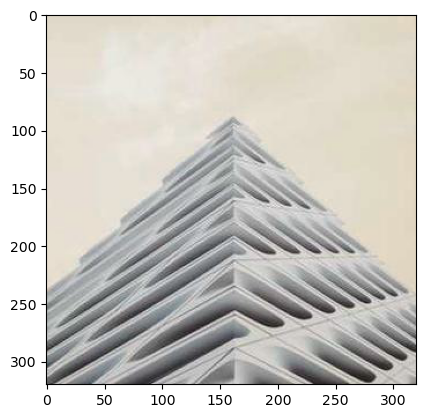

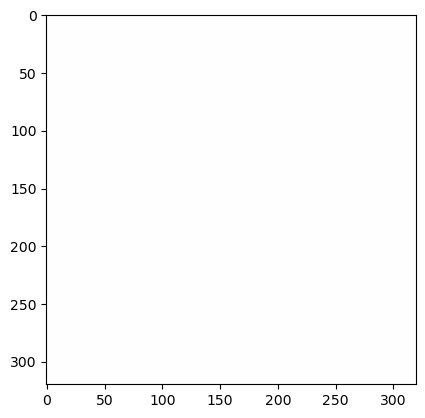

In [20]:
eval_out = autoencoder(test_data[:10])
eval_out = eval_out.view(-1, 3, IMG_SIZE, IMG_SIZE).permute(0, 2, 3, 1).cpu().detach().numpy()

plt.imshow(test_data[1].cpu().detach().permute(1, 2, 0).numpy() / 255)
plt.show()
plt.imshow(eval_out[0])
plt.show()